# Code Implementation

In [19]:
!ls

 class_names.txt
 foo.png
 helpers.py
 ImageSets
 JPEGImages
 losses.py
 model
 model_0.00003.h5
 model_0.05.h5
 output
 plot0.png
 plot1.png
 plot2.png
 plot3.png
'Preprocessing _and_visualization.ipynb'
 Pre-trained_weight_training.ipynb
 pr.py
 __pycache__
 ros_seg.py
 saved_figure.png
 Scratch_pretrained_Comarison-Copy1.ipynb
 Scratch_pretrained_Comarison.ipynb
 SegmentationClassPNG
 SegmentationClassSubset
 SegmentationClassVisualization
 Segmentation_testing.ipynb
 Segmentation_testing.py
 seg_ros.py
 test.py



Classes to detect, with corresponding colors:


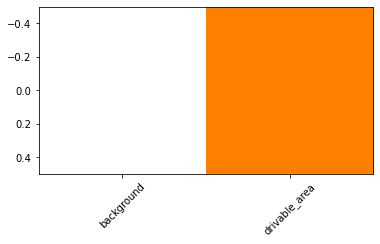

In [20]:
import sys
import cv2
import helpers
from helpers import *
%matplotlib inline
from matplotlib.colors import ListedColormap
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models
cmap_ref = cm.get_cmap('Set1', 12)
cmap_seg = np.zeros((6, 4))
cmap_seg[0] = [0.7, 0.7, 0.7, 0]
for i in range(1, 6):
  cmap_seg[i] = cmap_ref(i)

cmap_seg = ListedColormap(cmap_seg)
print("\nClasses to detect, with corresponding colors:")
plt.imshow([[0, 1]], cmap=cmap_seg)
plt.xticks([0,1], LABEL_NAMES[[0,1]], rotation=45)

INPUT_SPATIAL = 224

In [21]:
source_raw = 'JPEGImages'
source_mask = 'SegmentationClassSubset'

with open('ImageSets/Segmentation/train.txt', 'r') as fp:
    files_train = [line.rstrip() for line in fp.readlines()]

with open('ImageSets/Segmentation/val.txt', 'r') as fp:
    files_val = [line.rstrip() for line in fp.readlines()]

# Filter down to the subset we are using.
files_train = [f for f in files_train if os.path.isfile(os.path.join('SegmentationClassSubset/' + f + '.npy'))]
files_val = [f for f in files_val if os.path.isfile(os.path.join('SegmentationClassSubset/' + f + '.npy'))]

# Split train-validation into 80:20 instead of the original split.
files_all = np.array(sorted(list(set(files_train).union(set(files_val)))))
index = int(len(files_all) * 0.8)
files_train = files_all[:index]
files_val = files_all[index:]
print(len(files_train), 'training', len(files_val), 'validation')
labels = ['background', 'drivable_area']

370 training 93 validation


# Input Pipeline

In [22]:
gen_train = CustomDataGenerator(source_raw=source_raw,
                                source_mask=source_mask,
                                filenames=files_train.copy(),
                                batch_size=4,
                                target_height=INPUT_SPATIAL,
                                target_width=INPUT_SPATIAL)

gen_val = CustomDataGenerator(source_raw=source_raw,
                              source_mask=source_mask,
                              filenames=files_val.copy(),
                              batch_size=4,
                              target_height=INPUT_SPATIAL,
                              target_width=INPUT_SPATIAL)

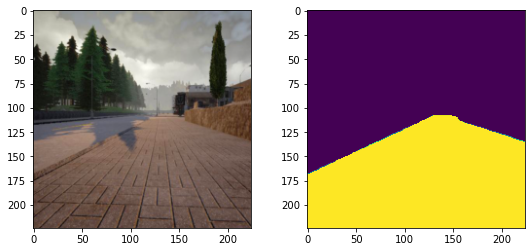

X shape (224, 224, 3) min-mean-max -0.9529411792755127 -0.23376437453798582 0.7803921699523926
Y shape (224, 224, 1) min-mean-max 0 0.4165736607142857 1


In [23]:
X, Y = gen_train[0]
X = X[0]
Y = Y[0]

plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.imshow(norm_vis(X, mode='rgb'))
plt.subplot(1, 2, 2)
plt.imshow(Y[:, :, 0])
plt.show()

print('X shape', X.shape, 'min-mean-max', X.min(), X.mean(), X.max())
print('Y shape', Y.shape, 'min-mean-max', Y.min(), Y.mean(), Y.max())

#  Network architecture

In [24]:
K.clear_session()

def get_fcn(pretrained=True, add_activation=True, verbose=False, n_outputs=1):
    def conv_block_simple(prev, num_filters, name):
        return Conv2D(num_filters, activation='relu', kernel_size=(3, 3), padding='same', name=name + '_3x3')(prev)

    selected_encoder = tf.keras.applications.mobilenet_v2.MobileNetV2(
        input_shape=(INPUT_SPATIAL, INPUT_SPATIAL, 3), 
        include_top=False, 
        alpha=1.0,
        weights='imagenet' if pretrained else None)
    for l in selected_encoder.layers:
        l.trainable = True
        if verbose:
            print(l.name, l.output.shape)
            
    conv0 = selected_encoder.get_layer("expanded_conv_project").output # 112 x 112
    conv1 = selected_encoder.get_layer("block_2_project").output # 56 x 56
    conv2 = selected_encoder.get_layer("block_5_project").output # 28 x 28
    conv3 = selected_encoder.get_layer("block_12_project").output # 14 x 14
   
    up6 = selected_encoder.output 
    conv7 = up6

    up8 = concatenate([UpSampling2D()(conv7), conv3], axis=-1)
    conv8 = conv_block_simple(up8, 128, "conv8_1")

    up9 = concatenate([UpSampling2D()(conv8), conv2], axis=-1)
    conv9 = conv_block_simple(up9, 64, "conv9_1")

    up10 = concatenate([UpSampling2D()(conv9), conv1], axis=-1)
    conv10 = conv_block_simple(up10, 32, "conv10_1")

    up11 = concatenate([UpSampling2D()(conv10), conv0], axis=-1)
    conv11 = conv_block_simple(up11, 32, "conv11_1")

    up12 = UpSampling2D()(conv11)
    conv12 = conv_block_simple(up12, 32, "conv12_1")

    x = Conv2D(N_CLASSES, (1, 1), activation=None, name="prediction")(conv12)
    
    if add_activation:
      x = tf.keras.layers.Activation("softmax")(x)

    model = tf.keras.Model(selected_encoder.input, [x] * n_outputs)
    if verbose:
        model.summary()
    return model

# Loss Function for Segmentation

In [25]:
def masked_loss(y_true, y_pred):
    """Defines a masked loss that ignores border/unlabeled pixels (represented as -1).
    
    Args:
      y_true: Ground truth tensor of shape [B, H, W, 1].
      y_pred: Prediction tensor of shape [B, H, W, N_CLASSES].
    """
    gt_validity_mask = tf.cast(tf.greater_equal(y_true[:, :, :, 0], 0), dtype=tf.float32) # [B, H, W]
    
    # The sparse categorical crossentropy loss expects labels >= 0. 
    # We just transform -1 into any valid class label, it will then be masked anyways.
    y_true = K.abs(y_true)
    raw_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)  # [B, H, W].

    masked = gt_validity_mask * raw_loss
    print(masked)
    
    return tf.reduce_mean(masked)
   

# Training the network from scratch



In [26]:
model_scratch = get_fcn(pretrained=False, verbose=False)
model_scratch.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00003), loss=masked_loss)

print('total number of model parameters:', model_scratch.count_params())

total number of model parameters: 3984034


In [27]:
history_scratch = model_scratch.fit(gen_train, epochs= 50, verbose=1, validation_data=gen_val)


Epoch 1/50
Tensor("masked_loss/mul:0", shape=(None, 224, 224), dtype=float32)
Tensor("masked_loss/mul:0", shape=(None, 224, 224), dtype=float32)
92/92 [==============================] - 8s 55ms/step - loss: 0.3276 - val_loss: 0.6885
Epoch 2/50
92/92 [==============================] - 5s 50ms/step - loss: 0.1819 - val_loss: 0.6823
Epoch 3/50
92/92 [==============================] - 4s 49ms/step - loss: 0.1596 - val_loss: 0.6934
Epoch 4/50
92/92 [==============================] - 5s 49ms/step - loss: 0.1508 - val_loss: 0.6819
Epoch 5/50
92/92 [==============================] - 5s 49ms/step - loss: 0.1411 - val_loss: 0.6532
Epoch 6/50
92/92 [==============================] - 5s 49ms/step - loss: 0.1328 - val_loss: 0.6400
Epoch 7/50
92/92 [==============================] - 5s 49ms/step - loss: 0.1326 - val_loss: 0.6278
Epoch 8/50
92/92 [==============================] - 5s 49ms/step - loss: 0.1251 - val_loss: 0.6343
Epoch 9/50
92/92 [==============================] - 5s 49ms/step - loss: 0

#  Visualize results

In [33]:
def run_patch_predict(model, img, deeplab=False):
    """Runs the segmentation model on a single image patch (224 x 224) with flipping.

    Args:
        img: Input image of shape [B, H=224, W=224, C=3] with intensities within range [0,1].

    Returns:
        Segmentation prediction of shape [B, H=224, W=224, N_CLASSES=6].
    """
    img = img.copy() * 255.  # Renorm to [0, 255].
    if not deeplab:
        img = tf.keras.applications.mobilenet_v2.preprocess_input(img)  # Pre-process for MobileNetv2
    else:
        img /= 255.

    left = model.predict(img)
    flip = np.flip(model.predict(np.flip(img, axis=2)), axis=2)

    if deeplab:
        left = left[:, :, CLASSES_TO_KEEP]
        flip = flip[:, :, CLASSES_TO_KEEP]

    return (left + flip) / 2

In [34]:
def show_examples(model, deeplab=False):
  for i in range(0,3):
    count = 350
    img = cv2.imread(os.path.join(source_raw, files_train[i] + '.jpg')).astype(np.float32) / 255.
    img = np.flip(img, axis=2)
    img = cv2.resize(img, (256, 256), cv2.INTER_LINEAR)
    gt = np.load(os.path.join(source_mask, files_train[i] + '.npy'))

    ret = run_predict(model, np.expand_dims(img, axis=0), deeplab=deeplab)[0]
    if ret.shape[-1] == 21:
      print("Reducing pedicted classes to the classes to keep.")
      ret = ret[:,:,:,CLASSES_TO_KEEP]
    ret_amax = np.argmax(ret, axis=2)

    plt.figure(figsize=(14, 4))
    plt.subplot(1, 3, 1)
    plt.title('input')
    plt.imshow(norm_vis(img, mode='rgb'))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('GT')
    plt.imshow(norm_vis(img, mode='rgb'))
    plt.imshow(gt[:, :, 0], cmap=cmap_seg, vmin=0, vmax=N_CLASSES, alpha=0.5)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Prediction')
    plt.imshow(norm_vis(img, mode='rgb'))
    plt.imshow(ret_amax, cmap=cmap_seg, vmin=0, vmax=N_CLASSES, alpha=0.5)
    plt.axis('off')

    plt.figure(figsize=(14, 4))
    for i, label in enumerate(labels[1:]):
        plt.subplot(1, 5, i+1)
        plt.title(label + ': ' + str(round(ret[:, :, i+1].mean(), 2)))
        plt.imshow(ret[:, :, i+1], vmin=0.0, vmax=1.0)
        plt.axis('off')

    plt.show()

# Visualization results from scratch

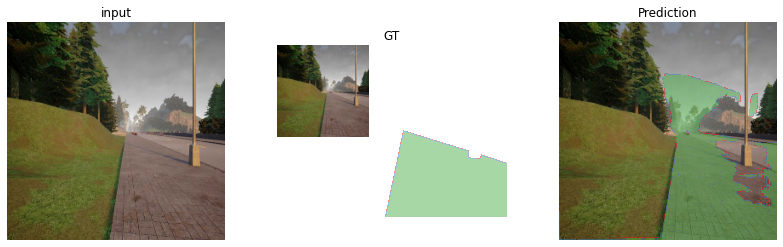

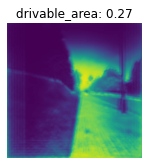

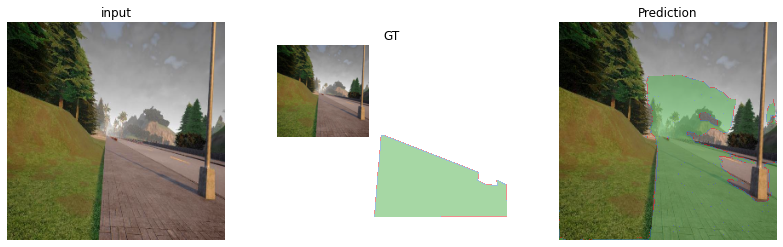

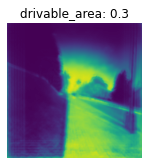

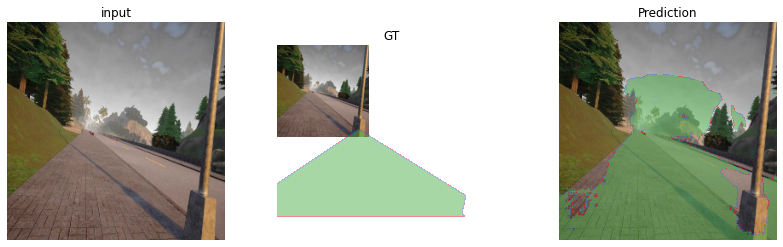

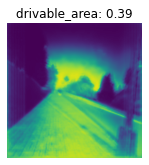

In [35]:
show_examples(model_scratch)


# Re-run training with pretrained encoder weights

In [36]:
model_pretrained = get_fcn(pretrained=True, verbose=False)
model_pretrained.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00003), loss=masked_loss)

print('total number of model parameters:', model_pretrained.count_params())

total number of model parameters: 3984034


In [37]:
history_model_pretrained = model_pretrained.fit(gen_train, epochs=50, verbose=1, validation_data=gen_val)


Epoch 1/50
Tensor("masked_loss/mul:0", shape=(None, 224, 224), dtype=float32)
Tensor("masked_loss/mul:0", shape=(None, 224, 224), dtype=float32)
92/92 [==============================] - 7s 54ms/step - loss: 0.5259 - val_loss: 0.2361
Epoch 2/50
92/92 [==============================] - 4s 48ms/step - loss: 0.1221 - val_loss: 0.1622
Epoch 3/50
92/92 [==============================] - 4s 49ms/step - loss: 0.0802 - val_loss: 0.1570
Epoch 4/50
92/92 [==============================] - 5s 49ms/step - loss: 0.0659 - val_loss: 0.1613
Epoch 5/50
92/92 [==============================] - 5s 49ms/step - loss: 0.0532 - val_loss: 0.1413
Epoch 6/50
92/92 [==============================] - 5s 49ms/step - loss: 0.0459 - val_loss: 0.1258
Epoch 7/50
92/92 [==============================] - 5s 49ms/step - loss: 0.0406 - val_loss: 0.1338
Epoch 8/50
92/92 [==============================] - 5s 49ms/step - loss: 0.0343 - val_loss: 0.1407
Epoch 9/50
92/92 [==============================] - 5s 49ms/step - loss: 0

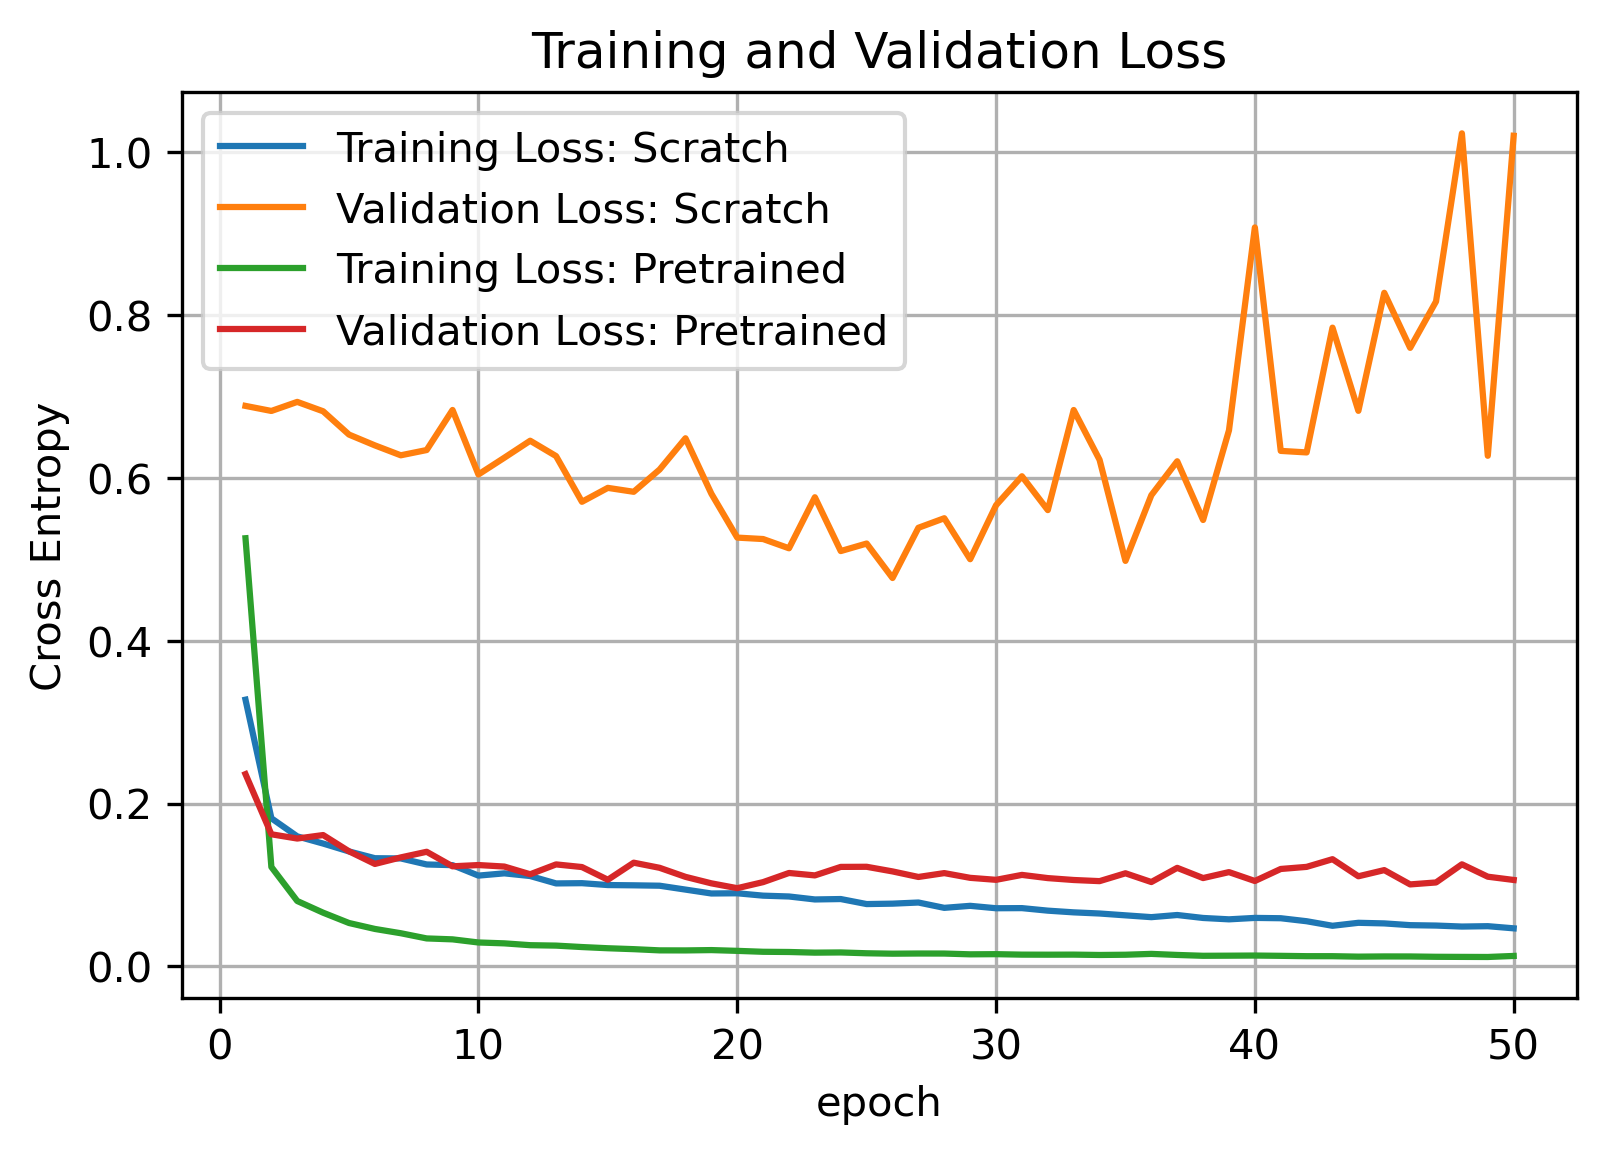

In [38]:
plot_history([history_scratch, history_model_pretrained], ['Scratch', 'Pretrained'])

# Save Training Model

In [ ]:
model_pretrained.save('weight_files/model_0.05.h5')

# Weighted IOU


In [ ]:
def jaccard_distance(y_true, y_pred):
    """Jaccard distance for semantic segmentation.

    Also known as the intersection-over-union loss.
    Jaccard = (|X & Y|) / (|X| + |Y| - |X & Y|)
            = sum(|A * B|) / (sum(|A|)+sum(|B|) - sum(|A * B|))

    Args:
        y_true: Ground truth segmentation mask.
        y_pred: Predicted segmentation mask.
    """
    intersection = np.sum(np.abs(y_true * y_pred))
    sum_ = np.sum(np.abs(y_true) + np.abs(y_pred))
    if (sum_ - intersection) == 0:
      jac = 0
    else: 
      jac = (intersection ) / (sum_ - intersection)
    return jac

models = [model_scratch, model_pretrained]
names  = ['model from scratch', 'pretrained model']

number_of_test_examples = 3

for i in range(number_of_test_examples):
  X, Y = gen_train[np.random.randint(100)]
  img = X[0]
  truth = cv2.resize(Y[0], (256, 256), interpolation=cv2.INTER_NEAREST)

  for model, name in zip(models, names):
    ret = run_predict(model, np.expand_dims(img, axis=0), deeplab=False)[0]
    arg_max_ret = np.argmax(ret, axis=2)
    weighted_iou = 0
    for c in range(N_CLASSES):
      class_truth = (truth == c).astype(np.float32)
      class_prediction = (arg_max_ret == c).astype(np.float32)
      weighted_iou = weighted_iou + np.sum(class_truth) * jaccard_distance(class_truth, class_prediction) / (class_truth.shape[0] * class_truth.shape[1])

    print(str(i) + ': For the ' + name + ': weighted_iou = ' + str(weighted_iou))
    
    

0: For the model from scratch: weighted_iou = 0.4308282621168473
0: For the pretrained model: weighted_iou = 0.6009693443775177
1: For the model from scratch: weighted_iou = 0.371701253550782


 # Qualitative results ro pre-trained model

In [ ]:
show_examples(model_pretrained)